In [6]:
import cv2
import mediapipe as mp
import time
from IPython.display import display, Image, clear_output

def video_show(frame, width=400, height=400):
    _, buffer = cv2.imencode(".jpg", frame)
    clear_output(wait=True)
    display(Image(data=buffer, width=width, height=height))

In [21]:
def video_pose_estimation(video_path, duration=10, width=640, height=480):
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    cap = cv2.VideoCapture(video_path)
    pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)
    fps = cap.get(cv2.CAP_PROP_FPS)
    start_time = time.time()

    points = [
        11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28
    ]

    while True:
        ret, frame = cap.read()
        if not ret: break
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        neck_x = (results.pose_landmarks.landmark[11].x + results.pose_landmarks.landmark[12].x) / 2
        neck_y = (results.pose_landmarks.landmark[11].y + results.pose_landmarks.landmark[12].y) / 2

        diff_x = (results.pose_landmarks.landmark[12].x - neck_x) - (results.pose_landmarks.landmark[25].x - neck_x)
        diff_y = (results.pose_landmarks.landmark[12].y - neck_y) - (results.pose_landmarks.landmark[25].y - neck_y)
        
        for idx, lm in enumerate(results.pose_landmarks.landmark):
            if idx in points:
                x = int((lm.x - neck_x) * image.shape[1])
                y = int((lm.y - neck_y) * image.shape[0])
                # x = int(lm.x * image.shape[1])
                # y = int(lm.y * image.shape[0])
                
                text_x = int(lm.x * image.shape[1])
                text_y = int(lm.y * image.shape[0])

                if idx % 2 == 0:
                    offset = -100
                else:
                    offset = 10

                cv2.circle(image, (int(neck_x * image.shape[1]), int(neck_y * image.shape[0])), 4, (255,0,0), -1)
                cv2.putText(image, f"({str(x)}, {str(y)})", (text_x + offset, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        video_show(image, width=640, height=480)
        #time.sleep(1/fps)

    cap.release()

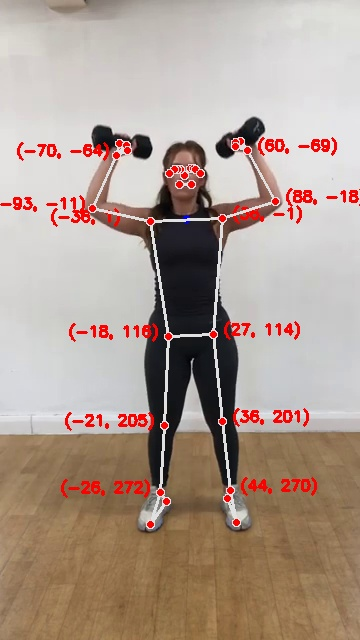

KeyboardInterrupt: 

In [23]:
video_name = "standing-dumbbell-shoulder-press-exercise-library_video_640p_original"
path = "/home/shin/Downloads/YOUTUBE_DL/youtube/video/" + video_name + ".mp4"
video_pose_estimation(path)